# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
   
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    ```
   
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * [Albumentations](https://github.com/albumentations-team/albumentations) is another awesome solution.
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.  
    * But sometimes there is! Some examples of advanced image augmentation approaches: [mixup](https://arxiv.org/pdf/1710.09412.pdf), [cutmix](https://arxiv.org/pdf/1905.04899.pdf)   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms

# Uncomment this to disable "Skipping walk through <class 'list'>" warnings in DataSphere's env
# %enable_full_walk
!nvidia-smi

In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dmitry/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

Wed Mar 17 15:37:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0 Off |                  N/A |
| 24%   37C    P8    16W / 160W |    594MiB /  5934MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# downloading TinyImagenet
# you don't have to run this cell more than once

from tiny_img import download_tinyImg200, fix_test_data
data_path = '.'
download_tinyImg200(data_path)
fix_test_data(data_path)

KeyboardInterrupt: 

# New Section

We will split `tiny-imagenet-200/train` dataset into train and val parts, and use  `tiny-imagenet-200/val` dataset as a test one.

You are free to use either the default ImageFolder Dataset, or the custom one, which will read and store the whole data in RAM. The second one is preferable only when you have a slow disk; make sure then you do have an extra couple of GiBs of memory (it also could take some time to load the images):

In [3]:
transform_train = transforms.Compose([
   torchvision.transforms.RandomRotation(45),
   transforms.RandomCrop(48, padding=0),
   transforms.Resize((64, 64)),
   transforms.RandomHorizontalFlip(p=0.5),
   transforms.ToTensor(),
   # torchvision.transforms.GaussianBlur(9, sigma=(0.1, 2.0))
   # transforms.Normalize([0, 0, 0], [1, 1, 1])
])


dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
                                                           generator=torch.Generator().manual_seed(42))
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transforms.ToTensor())

# OR

# from tiny_img_ram import TinyImagenetRAM
# dataset = TinyImagenetRAM('tiny-imagenet-200/train', transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
#                                                            generator=torch.Generator().manual_seed(42))
# test_dataset = TinyImagenetRAM('tiny-imagenet-200/val', transform=transforms.ToTensor())

In [9]:
# feel free to copypaste code from seminar03 as a basic template for training

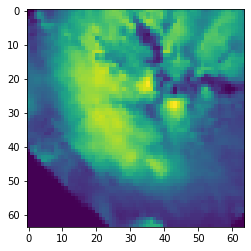

In [10]:
from matplotlib import pyplot as plt

plt.imshow(train_dataset[4][0][1])

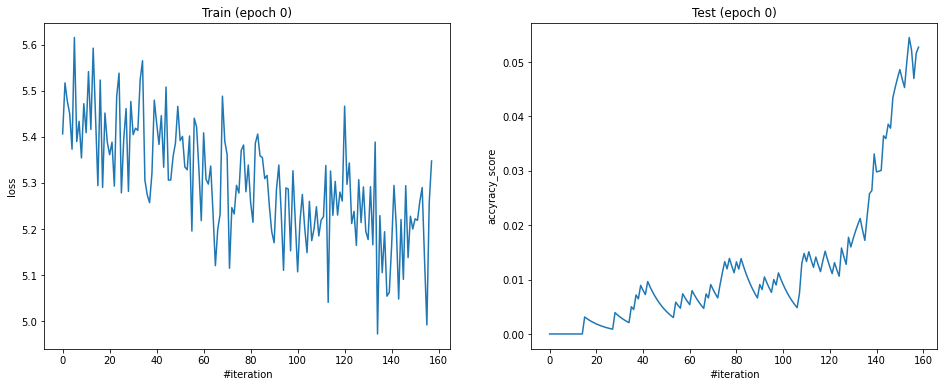


  5%|▌         | 158/3125 [03:11<18:39:56, 22.65s/it]

In [ ]:
import torchvision.models as models
from torch.utils.data import DataLoader, RandomSampler

import torch
from torch.optim import Adam
from IPython import display
from matplotlib import pyplot as plt
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange


def ema(collection, value, alpha=0.9):
  collection.append(collection[-1] * alpha + value * (1 - alpha))


device = torch.device('cuda:0')
batch_size = 32
n_epochs = 100
loss = nn.CrossEntropyLoss().to(device)
net = models.resnet18(num_classes=200, pretrained=False).to(device)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(len(train_loader), len(val_loader))

opt = Adam(net.parameters(), lr=1e-4)
loss_history = []
accuracy_history = [0]

for epoch in trange(n_epochs):
  for x, y in tqdm(train_loader):
    logits = net(x.to(device))
    l = loss(logits, y.to(device))
    l.backward()
    opt.step()
    net.zero_grad()
    loss_history.append(l.detach().cpu())

    with torch.no_grad():
        xval, yval = next(iter(val_loader))
        logits = net(xval.cuda())
        prob = F.softmax(logits).detach().cpu().numpy()
        y_pred = np.argmax(prob, axis=1)
        ema(accuracy_history, accuracy_score(yval.numpy(), y_pred))

    # Visualize
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

    ax1.set_title(f"Train (epoch {epoch})")
    ax1.set_xlabel("#iteration")
    ax1.set_ylabel("loss")
    ax1.plot(loss_history)

    ax2.set_title(f"Test (epoch {epoch})")
    ax2.set_xlabel("#iteration")
    ax2.set_ylabel("accyracy_score")
    ax2.plot(accuracy_history)
  
    plt.show()
    
    

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
y_pred = []
y_true = []
net = net.to(device).eval()
for x, y in tqdm(test_dataset):
  with torch.no_grad():
    logits = net(x.unsqueeze(dim=0).to(device))
    prob = F.softmax(logits).detach().cpu().numpy()
    y_pred.append(np.argmax(prob, axis=1))
    y_true.append(y)
print(y_pred)
test_acc = accuracy_score(y_true, y_pred)


test_accuracy = test_acc # YOUR CODE

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]